In [ ]:
from utils.pdb import pdb_to_npy, renumber_pdb, tmscore
from collections import defaultdict
import numpy as np
import pandas as pd
import os, functools, subprocess, tqdm
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.stats import linregress, pearsonr, spearmanr, kendalltau
tmscore = functools.cache(tmscore)

## Paths

In [2]:
PDBS_DIR = './structures'
SAMPLES_DIR = './pretrained_model/cameo2022.csv.ep7.num5.step0.5.alpha1.0.beta3.0.elbo0.2'

## Compute CAMEO results

In [3]:
DF = pd.read_csv('splits/cameo2022.csv', index_col='name')
df = pd.read_csv(SAMPLES_DIR + '.csv', index_col='path')
df['name'] = [path.split('/')[-1] for path in df.index]
df = df.set_index('name')
df = df[df.elbo_Y > -10] # remove 1 outlier sample which blew up

In [4]:
selected_df = pd.DataFrame([subdf.iloc[subdf.elbo_Y.argmax()] for key, subdf in df.groupby('name')])
for key in 'rmsd', 'tm', 'gdt_ts', 'lddt':
    print(key, '\t', 'mean', round(selected_df[key].mean(), 2), 'median', round(selected_df[key].median(), 2))

rmsd 	 mean 7.37 median 3.5
tm 	 mean 0.75 median 0.84
gdt_ts 	 mean 0.71 median 0.79
lddt 	 mean 0.78 median 0.85


## Load the structures for further analysis

In [5]:
def get_path_dict(sample_dir, df):
    print("Generating path dict...")
    path_dict = defaultdict(lambda: {
        'sample_paths' : [],
        'reference_path' : None
    })
    for name, row in tqdm.tqdm(df.iterrows()):
        pdb_key = name[:6]
        path_dict[pdb_key]['sample_paths'].append(os.path.join(sample_dir, f'{name}.{int(row["copy"])}.pdb'))
        path_dict[pdb_key]['reference_path'] = os.path.join('structures', pdb_key[:2], pdb_key + '.pdb')
    return path_dict

def get_seqres(pdb_path):
    pdb_filename = pdb_path.split('/')[-1]
    pdb_reference_filename = pdb_filename[:10]
    return DF.seqres[pdb_reference_filename]

def pdb_to_ac_npy(pdb_path):
    coords, _ = pdb_to_npy(pdb_path, seqres = get_seqres(pdb_path))
    return coords[:,0]

def get_structure_dict(path_dict):
    print("Generating structure dict...")
    def default_val():
        return {
            'samples_structures': [],
            'reference_structure': None,
        }
    structure_dict = defaultdict(default_val)
    for target_pdb_id, target_path_dict in tqdm.tqdm(list(path_dict.items())):
        try:
            structure_dict[target_pdb_id]['sample_structures'] = np.stack(list(map(pdb_to_ac_npy, target_path_dict['sample_paths'])))
            structure_dict[target_pdb_id]['reference_structure'] = pdb_to_ac_npy(target_path_dict['reference_path'])
        except Exception as e:
            print(f'Error opening {target_path_dict["sample_paths"][0]}') 
            raise e
    return structure_dict

In [6]:
path_dict = get_path_dict(SAMPLES_DIR, df)
structure_dict = get_structure_dict(path_dict)

Generating path dict...


914it [00:00, 24085.20it/s]


Generating structure dict...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:29<00:00,  6.19it/s]


## Compute ELBO - LDDT correlations

In [7]:
reg = linregress(df.elbo_Y, df.lddt)
print('Global correlation', round(reg.rvalue, 2))

Global correlation 0.82


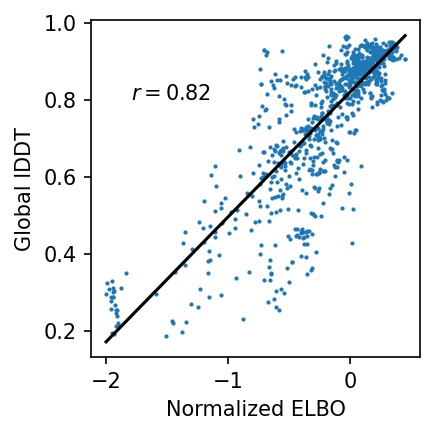

In [8]:
plt.figure(figsize=(3,3), dpi=150)
plt.ylabel('Global lDDT')
plt.xlabel('Normalized ELBO')
plt.plot(np.linspace(df.elbo_Y.min(), df.elbo_Y.max(), 10), reg.slope*np.linspace(df.elbo_Y.min(), df.elbo_Y.max(), 10)+reg.intercept, c='k')
plt.scatter(df.elbo_Y, df.lddt, s=1)
plt.text(-1.8, 0.8, f'$r = {round(reg.rvalue, 2)}$')
plt.tight_layout()

In [9]:
correls = {name: {
        'pearson': pearsonr(df[df.index == name].elbo_Y, df[df.index == name].lddt)[0],
        'spearman': spearmanr(df[df.index == name].elbo_Y, df[df.index == name].lddt).correlation,
        'kendall': kendalltau(df[df.index == name].elbo_Y, df[df.index == name].lddt).correlation
    } for name in set(df.index)}
correls = pd.DataFrame(correls).T

In [10]:
print('Per-target correlations: Mean', round(np.mean(correls.pearson), 2), 'Median', round(np.median(correls.pearson), 2))

Per-target correlations: Mean 0.42 Median 0.61


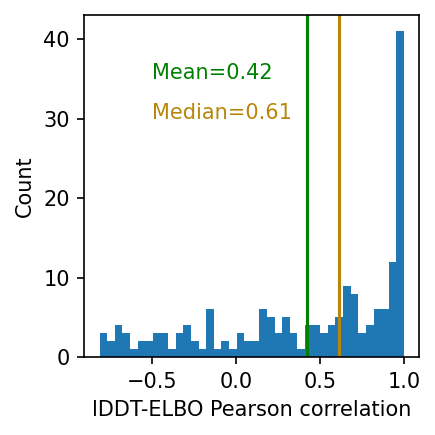

In [11]:
plt.figure(figsize=(3,3), dpi=150)
plt.xlabel('lDDT-ELBO Pearson correlation')
plt.ylabel('Count')
plt.axvline(np.mean(correls.pearson), c='g')
plt.axvline(np.median(correls.pearson), c='darkgoldenrod')
plt.text(-0.5, 35, f'Mean={round(np.mean(correls.pearson), 2)}', c='g')
plt.text(-0.5, 30, f'Median={round(np.median(correls.pearson), 2)}', c='darkgoldenrod')
_ = plt.hist(correls.pearson, bins=40)
plt.tight_layout()

## Protein-level error correlations

In [12]:
def tm_error_corr(path_dict, key='tm'):
    tm_pair_scores = []
    tm_ref_scores = []
    tm_target_corr_list = []
    for name, target_path_dict in tqdm.tqdm(list(path_dict.items())):
        sample_paths = target_path_dict['sample_paths']
        reference_path = target_path_dict['reference_path']
        num_samples = len(sample_paths)
        # compute average sample-sample error
        target_tm_pair_scores = []
        for i in range(num_samples):
            for j in range(i+1, num_samples):
                target_tm_score = tmscore(sample_paths[i], sample_paths[j], molseq=DF.seqres[name+'.pdb'])[key]
                target_tm_pair_scores.append(target_tm_score)
        tm_pair_scores.append(np.mean(np.array(target_tm_pair_scores)))
        
        # compute average sample-reference error
        target_tm_ref_scores = []
        for i in range(num_samples):
            target_tm_score = tmscore(reference_path, sample_paths[i], molseq=DF.seqres[name+'.pdb'])[key]
            target_tm_ref_scores.append(target_tm_score)
        tm_ref_scores.append(np.mean(np.array(target_tm_ref_scores)))
    
    tm_pair_scores = np.array(tm_pair_scores)
    tm_ref_scores = np.array(tm_ref_scores)
    
    not_nan_mask = ~np.isnan(tm_pair_scores) & ~np.isnan(tm_ref_scores)

    return tm_pair_scores[not_nan_mask], tm_ref_scores[not_nan_mask]     
                

In [13]:
for key in ['tm', 'gdt_ts', 'rmsd', 'lddt']:
    pair_scores, ref_scores = tm_error_corr(path_dict, key=key)
    print(key, round(pearsonr(pair_scores, ref_scores).statistic, 2))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [11:03<00:00,  3.63s/it]


tm 0.88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 4240.60it/s]


gdt_ts 0.9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 7908.24it/s]


rmsd 0.85


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 7792.62it/s]

lddt 0.86


## Residue-level LDDT error correlations

In [14]:
def parse_val_from_line(line):
    val = line.split('\t')[4]
    return float(val) if val != '-' else np.nan
              
def get_lddt_errors(lddt_out):
    residue_lines = list(filter(lambda line: len(line.split('\t')) > 4, lddt_out.split('\n')[11:]))
    return list(map(parse_val_from_line, residue_lines))

def lddt_error_correlation(path_dict):
    lddt_temp_dir = '/tmp/lddt' 
    if not os.path.exists(lddt_temp_dir): os.mkdir(lddt_temp_dir)
    lddt_pair_errors = []
    lddt_ref_errors = []
    lddt_target_corrs = []
    for target_path_dict in tqdm.tqdm(list(path_dict.values())):
            sample_paths = target_path_dict['sample_paths']
            num_samples = len(sample_paths)
            # first, compute lddt(s_i,s_j,k)
            target_lddt_pair_errors = []
            for i in range(num_samples):
                for j in range(i+1, num_samples):
                    args = ['lddt', '-c', sample_paths[i], sample_paths[j]]
                    lddt_out = subprocess.check_output(args, stderr=open('/dev/null', 'w')).decode('utf-8') # reference comes last
                    target_lddt_pair_error = get_lddt_errors(lddt_out)
                    target_lddt_pair_errors.append(target_lddt_pair_error)
            # average over pairs
            target_lddt_pair_errors = np.mean(np.array(target_lddt_pair_errors), axis=0)
            lddt_pair_errors.append(target_lddt_pair_errors)
            # now, compute lddt(s_i, ref, k), and reduce over k-dim to compute expectation
            target_lddt_ref_errors = []
            ref_path = target_path_dict['reference_path']
            seqres = get_seqres(ref_path)
            ref_renum = os.path.join(lddt_temp_dir, 'ref_renum.pdb')
            renumber_pdb(seqres, ref_path, ref_renum)
            for i in range(num_samples):
                args = ['lddt', '-c', sample_paths[i], ref_renum]
                lddt_out = subprocess.check_output(args,stderr=open('/dev/null', 'w')).decode('utf-8') # reference comes last
                target_lddt_ref_error = get_lddt_errors(lddt_out)
                target_lddt_ref_errors.append(target_lddt_ref_error)
            target_lddt_ref_errors = np.mean(np.array(target_lddt_ref_errors), axis=0)
            lddt_ref_errors.append(target_lddt_ref_errors)
            mask = ~np.isnan(target_lddt_pair_errors) & ~np.isnan(target_lddt_ref_errors)
            lddt_target_corrs.append(pearsonr(target_lddt_pair_errors[mask], target_lddt_ref_errors[mask])[0])
    lddt_pair_errors = np.concatenate(lddt_pair_errors)
    lddt_ref_errors = np.concatenate(lddt_ref_errors)
    not_nan_mask = np.argwhere(np.logical_and(~np.isnan(lddt_pair_errors), ~np.isnan(lddt_ref_errors)))
    lddt_target_corrs = np.array(lddt_target_corrs)
    return lddt_pair_errors, lddt_ref_errors, not_nan_mask, lddt_target_corrs

In [15]:
lddt_pair_errors, lddt_ref_errors, lddt_not_nan_mask, lddt_target_corrs = lddt_error_correlation(path_dict)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [03:52<00:00,  1.27s/it]


In [16]:
glob_correl = pearsonr(lddt_pair_errors[lddt_not_nan_mask].flatten(),  lddt_ref_errors[lddt_not_nan_mask].flatten())[0]
print('Global correlation', round(glob_correl, 2))
print('Per-target correlation: Mean', round(np.mean(lddt_target_corrs), 2), 'Median', round(np.median(lddt_target_corrs), 2))

Global correlation 0.88
Per-target correlation: Mean 0.73 Median 0.81


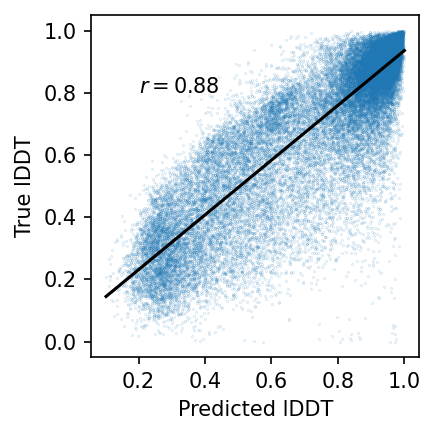

In [17]:
plt.figure(figsize=(3,3), dpi=150)
plt.xlabel('Predicted lDDT')
plt.ylabel('True lDDT')
np.random.seed(137)
random_mask = np.random.choice(np.arange(lddt_not_nan_mask.size), size=10000, replace=True) # otherwise takes too long
reg = linregress(lddt_pair_errors[lddt_not_nan_mask][random_mask].flat, lddt_ref_errors[lddt_not_nan_mask][random_mask].flat)
plt.plot(np.linspace(lddt_pair_errors.min(), lddt_pair_errors.max(), 10), reg.slope*np.linspace(lddt_pair_errors.min(), lddt_pair_errors.max(), 10)+reg.intercept, c='k')
plt.scatter(lddt_pair_errors, lddt_ref_errors, s=0.005)
plt.text(0.2, 0.8, f'$r = {round(glob_correl, 2)}$')
plt.tight_layout()

## Residue-level aligned position error correlations

In [18]:
def align_structures(struct1_fixed, struct2_fixed):
    struct1 = struct1_fixed - np.nanmean(struct1_fixed, 0)
    struct2 = struct2_fixed - np.nanmean(struct2_fixed, 0)
    mask = ~np.isnan(struct1[:,0]) & ~np.isnan(struct2[:,0])
    
    rot = R.align_vectors(struct1[mask], struct2[mask])[0].as_matrix()
    struct2 = struct2 @ rot.T
    return struct1, struct2

def residue_sd(structure1, structure2):
    return np.sum(np.square(structure1 - structure2), axis=-1)**0.5

def rmsd_error_correlation(structure_dict):
    rmsf_list = []
    rmsd_list = []
    target_corr_list = []
    for target_structure_dict in tqdm.tqdm(list(structure_dict.values())):
        sample_structures = target_structure_dict['sample_structures']
        reference_structure = target_structure_dict['reference_structure']
        num_samples = len(sample_structures)
        
        # compute sample rmsf
        target_rmsf_list = []
        for i in range(num_samples):
            for j in range(i+1, num_samples):
                aligned_sample1, aligned_sample2 = align_structures(sample_structures[i], sample_structures[j])
                target_rmsf = residue_sd(aligned_sample1, aligned_sample2)
                target_rmsf_list.append(target_rmsf)
        target_rmsf_list = np.mean(np.stack(target_rmsf_list), axis=0)
        rmsf_list.append(target_rmsf_list)
        
        # compute sample-reference rmsd
        target_rmsd_list = []
        for i in range(num_samples):
            aligned_sample, aligned_ref = align_structures(sample_structures[i], reference_structure)
            target_rmsd = residue_sd(aligned_sample, aligned_ref)
            target_rmsd_list.append(target_rmsd)
        target_rmsd_list = np.mean(np.stack(target_rmsd_list), axis=0)
        rmsd_list.append(target_rmsd_list)
        
        mask = ~np.isnan(target_rmsf_list) & ~np.isnan(target_rmsd_list)
        target_corr_list.append(pearsonr(target_rmsf_list[mask], target_rmsd_list[mask])[0])
    
    rmsf_list = np.concatenate(rmsf_list)
    rmsd_list = np.concatenate(rmsd_list)
    
    not_nan_mask = ~np.isnan(rmsf_list) & ~np.isnan(rmsd_list)
    
    target_corr_list = np.array(target_corr_list)

    return rmsf_list, rmsd_list, not_nan_mask, target_corr_list


In [19]:
rmsf_list, rmsd_list, rmsd_not_nan_mask, rmsd_target_corrs = rmsd_error_correlation(structure_dict)
print('Global correlation', round(pearsonr(rmsf_list[rmsd_not_nan_mask], rmsd_list[rmsd_not_nan_mask])[0], 2))
print('Per-target correlation: Mean', round(np.mean(rmsd_target_corrs), 2), 'Median', round(np.median(rmsd_target_corrs), 2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:01<00:00, 127.95it/s]

Global correlation 0.8
Per-target correlation: Mean 0.68 Median 0.75


## Pairwise distance error correlations

In [20]:
def get_pairwise_distances(structure):
    return np.sqrt(np.sum(np.square(structure[...,None,:] - structure[...,None,:,:]), -1))

def get_pearson(entry):
    std = np.std(get_pairwise_distances(entry['sample_structures']), axis=0).flatten()
    pairwise_dist_squares = np.abs(get_pairwise_distances(entry['sample_structures'][get_best_elbo_idx(entry)]) \
                                   - get_pairwise_distances(entry['reference_structure'])).flatten()
    not_nan_mask = ~np.isnan(pairwise_dist_squares)
    return pearsonr(std[not_nan_mask], pairwise_dist_squares[not_nan_mask])[0]
                    
def pairwise_distance_error_correlation(structure_dict): 
    correls = []
    all_true_errs = []
    all_pred_errs = []
    for target_structure_dict in tqdm.tqdm(list(structure_dict.values())):
        sample_structures = target_structure_dict['sample_structures']
        reference_structure = target_structure_dict['reference_structure']
        num_samples = len(sample_structures)
        
        dist = get_pairwise_distances(sample_structures)
        pred_err = np.abs(dist[None] -dist[:,None]).mean((0, 1))
        true_err = np.abs(get_pairwise_distances(sample_structures) - get_pairwise_distances(reference_structure)).mean(0)
        not_nan_mask = ~np.isnan(pred_err.flat) & ~np.isnan(true_err.flat)
        correls.append(pearsonr(pred_err.flat[not_nan_mask], true_err.flat[not_nan_mask])[0])
        all_true_errs.append(true_err.flat)
        all_pred_errs.append(pred_err.flat)
    
    return correls, np.concatenate(all_pred_errs), np.concatenate(all_true_errs)

In [21]:
correls, pred_err, true_err = pairwise_distance_error_correlation(structure_dict)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:19<00:00,  9.54it/s]


In [22]:
not_nan_mask = ~np.isnan(pred_err) & ~np.isnan(true_err)
print('Global correlation:', round(pearsonr(pred_err[not_nan_mask], true_err[not_nan_mask])[0], 2))
print('Per-target correlation: Mean', round(np.mean(correls), 2), 'Median', round(np.median(correls), 2))

Global correlation: 0.75
Per-target correlation: Mean 0.69 Median 0.72


In [23]:
def get_pairwise_plots(i):
    target_structure_dict = structure_dict[list(structure_dict.keys())[i]]
    sample_structures = target_structure_dict['sample_structures']
    reference_structure = target_structure_dict['reference_structure']        
    dist = get_pairwise_distances(sample_structures)
    pred_err = np.abs(dist[None] -dist[:,None]).mean((0, 1))
    true_err = np.abs(get_pairwise_distances(sample_structures) - get_pairwise_distances(reference_structure)).mean(0)
    not_nan_mask = ~np.isnan(reference_structure[:,0])
    return pred_err[not_nan_mask][:,not_nan_mask], true_err[not_nan_mask][:,not_nan_mask]

Text(0, 0.5, '7t12.B')

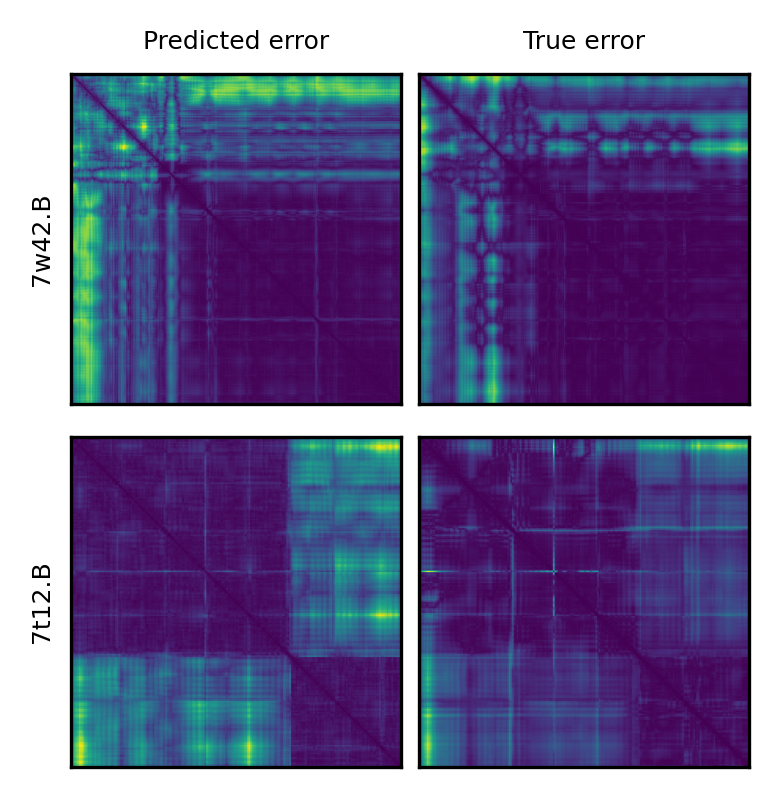

In [24]:
# If you re-run inference the plots will probably be different
fig = plt.figure(figsize=(3, 3), dpi=300)
axs = fig.subplots(2, 2, sharex=False, sharey=False)
for ax in axs.flatten():
    ax.set_xticks([]); ax.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0.1)
pred_err, true_err = get_pairwise_plots(17)
axs[0,0].imshow(pred_err)
axs[0,1].imshow(true_err)
axs[0,0].set_title('Predicted error', fontsize=6)
axs[0,1].set_title('True error', fontsize=6)
axs[0,0].set_ylabel(list(structure_dict.keys())[17], fontsize=6)

pred_err, true_err = get_pairwise_plots(14)
axs[1,0].imshow(pred_err)
axs[1,1].imshow(true_err)
axs[1,0].set_ylabel(list(structure_dict.keys())[14], fontsize=6)